In [10]:
%pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
import math
from scipy import ndimage
from skimage import measure
import numpy as np

In [12]:
def get_file_path(iq_number):
    # Convert number (1-10) to file path "iq_images/iq{i}.png" but with a leading zero if i < 10
    return f"iq_images/iq{str(iq_number).zfill(2)}.png"

def get_image(file_path):
    original_image = cv2.imread(file_path)
    return original_image

def get_grayscale_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def get_contours(image, isGray = False, isBinary = False):
    gray = get_grayscale_image(image) if not isGray else image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV) if not isBinary else (0, image)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # it is possible a contour is found around the border of the image, so remove it
    threshold = 0.95
    contours = [contour for contour in contours if cv2.contourArea(contour) / (image.shape[0] * image.shape[1]) < threshold]
    return contours

def align_images(image1, image2, same_shape = False):
    a_contours = get_contours(image1, False)
    b_contours = get_contours(image2, False)
    # show_image(draw_contours(image1, a_contours))
    a_contours = sorted(a_contours, key=cv2.contourArea, reverse=True)
    b_contours = sorted(b_contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(a_contours[0])
    image1 = image1[y:y+h, x:x+w]
    x, y, w, h = cv2.boundingRect(b_contours[0])
    image2 = image2[y:y+h, x:x+w]
    if same_shape:
        # Grow the smaller image to the size of the larger image
        if image1.shape[0] > image2.shape[0]:
            image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
        else:
            image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))
    return image1, image2

def remove_background(image1, image2):
    base = cv2.bitwise_and(image1, image2)
    image1 = cv2.bitwise_xor(image1, base)
    image2 = cv2.bitwise_xor(image2, base)
    # clean up the images
    image1 = cv2.medianBlur(image1, 5)
    image2 = cv2.medianBlur(image2, 5)
    return image1, image2

def process_images(image1, image2, align = True, remove_bg = True):
    # Align the images
    if align:
        image1, image2 = align_images(image1, image2, True)
    # Remove the background
    if remove_bg:
        image1, image2 = remove_background(image1, image2)
    else:
        # apply a median blur to the images to remove noise
        image1 = cv2.medianBlur(image1, 5)
        image2 = cv2.medianBlur(image2, 5)
    # convert them to binary images
    # _, image1 = cv2.threshold(get_grayscale_image(image1), 128, 255, cv2.THRESH_BINARY_INV)
    # _, image2 = cv2.threshold(get_grayscale_image(image2), 128, 255, cv2.THRESH_BINARY_INV)
    
    return image1, image2

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def show_images_grid(images):
    # Display the cropped images for visual verification
    grid_size = np.sqrt(len(images))
    # round up to the nearest integer
    grid_size = math.ceil(grid_size)
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def draw_contours(image, contours, same_color=False):
    # Rainbow colors in BGR format
    rainbow_colors = [
        (0, 0, 255),     # Red
        (0, 165, 255),   # Orange
        (0, 255, 255),   # Yellow
        (0, 255, 0),     # Green
        (255, 0, 0),     # Blue
        (130, 0, 75),    # Indigo
        (238, 130, 238)  # Violet
    ]

    image_with_contours = image.copy()
    
    # Loop through contours and colors
    for i, contour in enumerate(contours):
        color = rainbow_colors[i % len(rainbow_colors)] if not same_color else (0, 255, 0)
        cv2.drawContours(image_with_contours, [contour], -1, color, 2)

    return image_with_contours

In [13]:
def get_possible_answers(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Thresholding to get binary image
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Function to get contour pre-sort area
    def get_contour_precedence(contour, cols):
        tolerance_factor = 10
        origin = cv2.boundingRect(contour)
        return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

    # Sort the contours left-to-right, top-to-bottom
    sorted_contours = sorted(contours, key=lambda x: get_contour_precedence(x, img.shape[1]))

    # Initialize list to hold the cropped images
    cropped_images = []
    # also keep track of the bounding boxes from the original image
    bounding_boxes = []

    # Loop over the contours and extract the image sections
    for c in sorted_contours:
        # Get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        # Crop the image to the bounding rect
        if w * h > 1000:  # to make sure it is not noise and is indeed a block
            cropped_img = img[y:y + h, x:x + w]
            cropped_images.append(cropped_img)
            bounding_boxes.append((x, y, w, h))
    return cropped_images, bounding_boxes


def get_grid_images(image):

    # Apply adaptive thresholding to get a binary image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest rectangle contour which should be the grid
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding box
    cropped_grid = image[y:y+h, x:x+w]

    # Split the grid into 9 equal parts
    grid_size = 3
    cell_width = w // grid_size
    cell_height = h // grid_size

    # Save each cell as its own image
    cells = []
    
    for i in range(grid_size):
        for j in range(grid_size):
            cell = cropped_grid[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
            edge_remove = 6 # remove a number of pixels from each side (to remove the grid lines)
            cell = cell[edge_remove:cell.shape[0]-edge_remove, edge_remove:cell.shape[1]-edge_remove]
            cells.append(cell)
    
    # return the cells and the bounding box of the grid
    return cells, (x, y, w, h)


def get_possible_answers_simple_helper():
    first_image = get_image(get_file_path(1))
    cells, (x, y, w, h) = get_grid_images(first_image)
    # get the y level of the bottom of the grid
    y_level = y + h
    # get half of the image, below a y level
    half_image = first_image[y_level:, :]
    test_images, bounding_boxes = get_possible_answers(half_image)
    # show_images_grid(test_images)
    return bounding_boxes
bounding_boxes = get_possible_answers_simple_helper()
def get_possible_answers_simple(img):
    # Use known bounding boxes to crop the images
    cropped_images = []
    for (x, y, w, h) in bounding_boxes:
        cropped = img[y:y + h, x:x + w]
        cropped_images.append(cropped)
    return cropped_images

def get_possible_answers_2(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Function to get contour pre-sort area
    def get_contour_precedence(contour, cols):
        tolerance_factor = 10
        origin = cv2.boundingRect(contour)
        return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]


    # Apply adaptive thresholding to invert the images and make the digits appear white (foreground) on black background
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours left-to-right, top-to-bottom
    sorted_contours = sorted(contours, key=lambda x: get_contour_precedence(x, img.shape[1]))

    # Assuming the images are arranged in a grid, calculate the expected number of images
    expected_images = 6  # As per the previous layout

    # Initialize a list to store the bounding boxes of expected images
    bounding_boxes = []

    # Calculate the average contour width and height
    average_width = sum([cv2.boundingRect(c)[2] for c in sorted_contours]) / len(sorted_contours)
    average_height = sum([cv2.boundingRect(c)[3] for c in sorted_contours]) / len(sorted_contours)

    # Determine the expected width and height threshold to filter out non-image contours
    width_threshold = average_width * 0.5
    height_threshold = average_height * 0.5

    # Filter contours that meet the expected width and height threshold
    for c in sorted_contours:
        x, y, w, h = cv2.boundingRect(c)
        if w > width_threshold and h > height_threshold:
            bounding_boxes.append((x, y, w, h))

    # Now, assuming the top left corner of the blocks are the starts of our images
    # We should sort them top-to-bottom first, and then within each row left-to-right
    bounding_boxes = sorted(bounding_boxes, key=lambda b: (b[1], b[0]))

    # Adjusting our approach, we will now assume the blocks themselves are not consistent
    # And instead we will look at the bounding box of the whole selection area and divide it evenly
    if len(bounding_boxes) > 0:
        # Calculate the bounding box of the whole selection area
        start_x = min([b[0] for b in bounding_boxes])
        start_y = min([b[1] for b in bounding_boxes])
        end_x = max([b[0] + b[2] for b in bounding_boxes])
        end_y = max([b[1] + b[3] for b in bounding_boxes])

        # Calculate the individual cell width and height
        cell_width = (end_x - start_x) / 3
        cell_height = (end_y - start_y) / 2

        # Create 6 bounding boxes assuming a 3x2 grid
        grid_bounding_boxes = [(start_x + (i % 3) * cell_width, start_y + (i // 3) * cell_height, cell_width, cell_height) for i in range(6)]
    else:
        # If no blocks were found, we'll need to revert to another strategy
        grid_bounding_boxes = []

    # If we have 6 bounding boxes, then crop the images
    cropped_images = []
    if len(grid_bounding_boxes) == expected_images:
        for (x, y, w, h) in grid_bounding_boxes:
            cropped = img[int(y):int(y + h), int(x):int(x + w)]
            cropped_images.append(cropped)
    else:
        # No bounding boxes were found, which means our method failed
        print("The method failed to identify the bounding boxes of the images.")
    return cropped_images
def get_possible_answers_3(image):
    # Convert the image to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use thresholding to binarize the image
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get bounding boxes for each contour
    bounding_boxes = [cv2.boundingRect(c) for c in contours]

    # Sort the bounding boxes from top-left to bottom-right
    bounding_boxes.sort(key=lambda x: (x[1], x[0]))

    return bounding_boxes

def get_possible_answers_4(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lower_blue = np.array([200, 200, 220])  # light blue range
    upper_blue = np.array([250, 250, 255])  # white range

    # Create a mask to only select blue
    mask = cv2.inRange(img_rgb, lower_blue, upper_blue)
    show_image(mask)

def iq_test_to_squares(image):
    cells, (x, y, w, h) = get_grid_images(image)

    # Get the 6 possible answers

    # get the y level of the bottom of the grid
    y_level = y + h
    # get half of the image, below a y level
    half_image = image[y_level:, :]
    possible_answers = get_possible_answers_simple(half_image)
    # print(f"Found {len(possible_answers)} possible answers")
    # show_images_grid(possible_answers)
    # show_image(half_image)

    # show_image(draw_contours(half_image, get_contours(half_image)))
    # show_image(half_image)
    # invert the colors (black to white, white to black)
    for i in range(len(cells)):
        cells[i] = cv2.bitwise_not(cells[i])
        # Convert pixels to 0 or 1
        # cells[i] = (cells[i] < 128).astype(np.uint8)

    return cells#, possible_answers

# show_image(iq_test_to_squares(get_image(get_file_path(1)))[1][0])
# for i in range(35):
#     print(i+1)
#     cells = iq_test_to_squares(get_image(get_file_path(i+1)))
# show_images_grid(cells)
# show_image(cells[0])

In [14]:
imgs = iq_test_to_squares(get_image('iq_images/iq17.png'))

def shift(image, dx, dy):
    transformation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    return cv2.warpAffine(image, transformation_matrix, (image.shape[1], image.shape[0]))


def RotateAugmentation(angle):
    """
    Rotate clockwise by the given angle.
    """
    def rotate(image):
        return ndimage.rotate(image, -angle, reshape=False)
    return rotate

def CropAugmentation(x, y, w, h):
    def crop(image):
        return image[y:y+h, x:x+w]
    return crop

def TranslateAugmentation(dx, dy):
    def translate(image):
        # return ndimage.shift(image, (dy, dx, 0))
        # Shift the image
        translated_image = ndimage.shift(image, (dy, dx, 0), mode='nearest')

        blank_color = [255, 255, 255]
        blank_color = [0, 0, 0]
        blank_color = 0
        if dy > 0:  # Shifted down
            translated_image[:dy, :] = blank_color
        elif dy < 0:  # Shifted up
            translated_image[dy:, :] = blank_color

        if dx > 0:  # Shifted right
            translated_image[:, :dx] = blank_color
        elif dx < 0:  # Shifted left
            translated_image[:, dx:] = blank_color

        return translated_image
    return translate

def ScaleAugmentation(sx, sy):
    def scale(image):
        return cv2.resize(image, (0, 0), fx=sx, fy=sy)
    return scale

def ShearAugmentation(shear):
    def shear(image):
        shear_matrix = np.array([
            [1, shear],
            [0, 1]
        ])
        return cv2.warpAffine(image, shear_matrix, (image.shape[1], image.shape[0]))
    return shear

def ColorChangeAugmentation(shift):
    def color_change(image):
        return image + shift
    return color_change

def FlipAugmentation(angle):
    """
    Flip the image by the given angle, crossing the center of the image.
    Angle is in degrees. 0 is a vertical axis, going clockwise, 180 is a horizontal axis.
    """
    # Base angle type goes counterclockwise, reverse this
    angle = -angle
    def flip(image):
        # Calculate the center of the image
        center = np.array(image.shape[:2])[::-1] / 2.0
        
        # Compute the transformation matrix
        rotation_matrix = cv2.getRotationMatrix2D(tuple(center), angle, 1.0)
        
        # Perform the affine transformation
        rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], flags=cv2.INTER_LINEAR)
        
        return rotated_image

    return flip

def augmentation_score(augmentation, org_img, dest_img):
    augmented_image = augmentation(org_img)
    # Rules that make an augmented imge good:
    # 1. It should be similar to the destination image
    # 2. It should have a similar structure to the original image (like number of colored pixels)
    l2 = np.mean((augmented_image - dest_img) ** 2)
    y_size = np.sum(dest_img > 0)
    augmented_size = np.sum(augmented_image > 0)
    return l2 / (y_size * augmented_size)
    return l2 * (1 + (abs(y_size - augmented_size) / y_size))
    return np.mean((augmented_image - dest_img) ** 2)

def avg_augmentation_score(augmentation, images):
    # Get all transitions from one image to another as pairs of images
    transitions = [(images[i], images[i+1]) for i in range(len(images) - 1)]
    # Calculate the score for each transition
    scores = [augmentation_score(augmentation, img1, img2) for img1, img2 in transitions]
    # Return the average score
    return np.mean(scores)


Original:


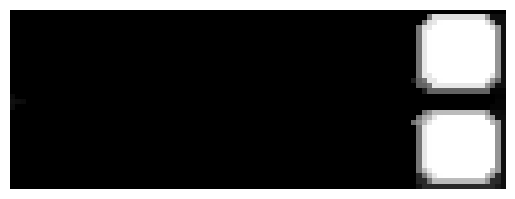

Destination:


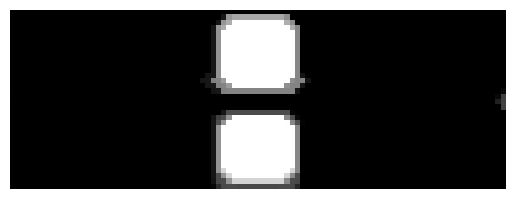

Trying to find the best offset


/tmp/ipykernel_59842/667095701.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  return l2 / (y_size * augmented_size)


Best offset: (-39, 0), score: 2.9495437787904538e-06
Best offset of (-39, 0) with image:


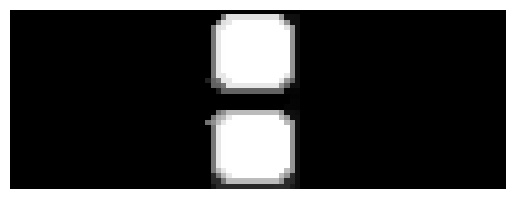

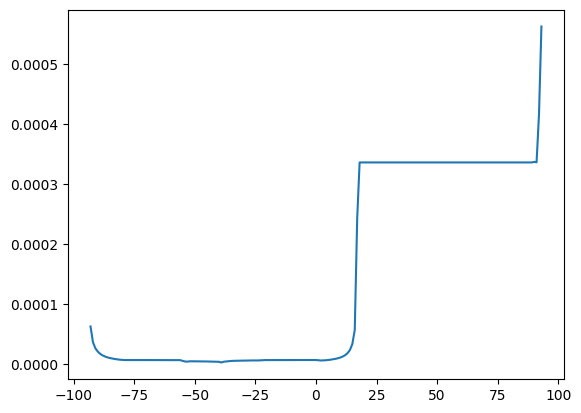

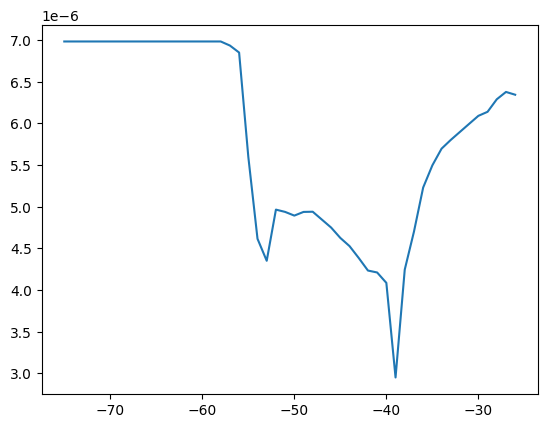

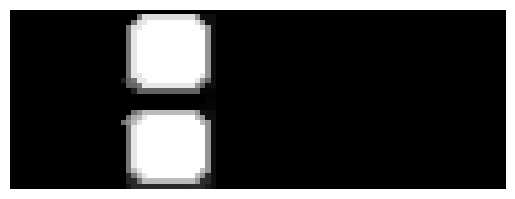

In [15]:
# New approach: Use Gradient Descent or similar to learn the parameters of the augmentation.
# We have base augmentations: Rotate, Flipping, Stretching, Cropping, Color change, and Translation. (Potential: bitwise logic like XOR)

def get_angle(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(-180, 180)
    best_angle = None
    best_score = float('inf')
    for angle in angles:
        score = augmentation_score(RotateAugmentation(angle), org, dest)
        if score < best_score:
            best_score = score
            best_angle = angle
    print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score

def get_offset(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    for dx in range(-width, width):
        for dy in range(-height, height):
            translated = TranslateAugmentation(dx, dy)(org)
            score = np.sum(np.abs(translated - dest))
            if score < best_score:
                best_score = score
                best_offset = (dx, dy)
    print(f"Best offset: {best_offset}, score: {best_score}")
    return best_offset, best_score

def get_offset_x(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    for dx in range(-width, width):
        # translated = TranslateAugmentation(dx, 0)(org)
        # score = np.sum(np.abs(translated - dest))
        score = augmentation_score(TranslateAugmentation(dx, 0), org, dest)
        if score < best_score:
            best_score = score
            best_offset = (dx, 0)
    print(f"Best offset: {best_offset}, score: {best_score}")
    return best_offset, best_score
def get_mirror_angle(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(0, 180)
    best_angle = None
    best_score = float('inf')
    for angle in angles:
        flipped = FlipAugmentation(angle)(org)
        score = np.sum(np.abs(flipped - dest))
        if score < best_score:
            best_score = score
            best_angle = angle
    print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score

def test_rotation():
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org, dest = data[1], data[2]
    org, dest = process_images(org, dest, remove_bg=True, align=True)
    show_image(org)
    show_image(dest)
    # Need them to have the same size
    angle, score = get_angle(org, dest)
    print(f"Best angle of {angle} with image:")
    aug_img = RotateAugmentation(angle)(org)
    show_image(aug_img)
    angle_test = 90
    print(f"Trying an angle of {angle_test}")
    aug_img = RotateAugmentation(angle_test)(org)
    show_image(aug_img)

    # Try plotting the score for different angles
    angles = range(-180, 180)
    scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.plot(angles, scores)
    plt.show()

    
    print("Try rotation")
    
    offset_x = range(-org.shape[1], org.shape[1])
    scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.title("Translation X score")
    plt.plot(offset_x, scores)
    plt.xlabel("Offset (pixels)")
    plt.show()
    offset_y = range(-org.shape[0], org.shape[0])
    scores = [augmentation_score(TranslateAugmentation(0, dy), org, dest) for dy in offset_y]
    plt.title("Translation Y score")
    plt.plot(offset_y, scores)
    plt.xlabel("Offset (pixels)")
    plt.show()


def test_translation():
    # Testing translation
    data = iq_test_to_squares(get_image('iq_images/iq04.png'))
    org = data[0]
    dest = data[1]
    org, dest = process_images(org, dest, remove_bg=True)
    print("Original:")
    show_image(org)
    print("Destination:")
    show_image(dest)
    print("Trying to find the best offset")

    final_offset, score = get_offset_x(org, dest)
    aug_img = TranslateAugmentation(final_offset[0], final_offset[1])(org)
    print(f"Best offset of {final_offset} with image:")
    show_image(aug_img)

    # Try plotting the score for different offsets
    offset_x = range(-org.shape[1], org.shape[1])
    # offset_x = range(-75, -25)
    scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.plot(offset_x, scores)
    plt.show()
    
    # Try plotting the score for different offsets
    # offset_x = range(-org.shape[1], org.shape[1])
    offset_x = range(-75, -25)
    scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.plot(offset_x, scores)
    plt.show()

    # show what happens when we translate by -55
    test_offset = -55
    aug_img = TranslateAugmentation(test_offset, 0)(org)
    show_image(aug_img)

    

def plot_different_augmentations():
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    
    org, dest = process_images(org, dest, remove_bg=True)
    show_image(org)
    show_image(dest)
    angles = range(-180, 180)
    scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.title("Rotation score")
    plt.plot(angles, scores)
    plt.xlabel("Angle (degrees)")
    plt.show()
    offset_x = range(-org.shape[1], org.shape[1])
    scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.title("Translation X score")
    plt.plot(offset_x, scores)
    plt.xlabel("Offset (pixels)")
    plt.show()
    offset_y = range(-org.shape[0], org.shape[0])
    scores = [augmentation_score(TranslateAugmentation(0, dy), org, dest) for dy in offset_y]
    plt.title("Translation Y score")
    plt.plot(offset_y, scores)
    plt.xlabel("Offset (pixels)")
    plt.show()

    # try translate x by 60
    aug_img = TranslateAugmentation(60, 0)(org)
    show_image(aug_img)
    # try translate y by 72
    aug_img = TranslateAugmentation(0, 72)(org)
    show_image(aug_img)
    # try translate y by -90
    aug_img = TranslateAugmentation(0, -90)(org)
    show_image(aug_img)
    


# map = test_rotate_4()
# test_rotation()
test_translation()
# plot_different_augmentations()

iq04 - Boxes translating
Correct labels: 
[['Translate (-50, 0)', 'Translate (-50, 0)'], ['Translate (-50, -50)', 'Translate (-50, -50)'], ['Translate (0, -50)', 'N/A']]


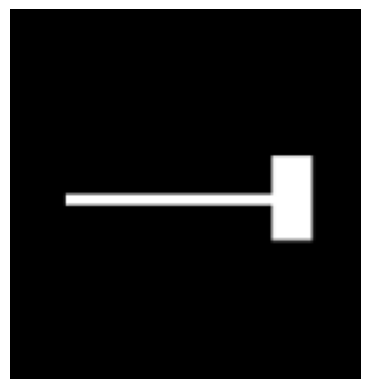

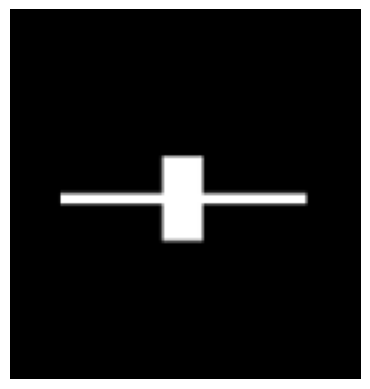

Optimal parameter for Rotate: 1, score: 2.2303897636232613e-06
Optimal parameter for Translate X: -37, score: 1.9874416274393223e-06
Optimal parameter for Translate Y: 7, score: 2.3758806713157386e-06
Translate X


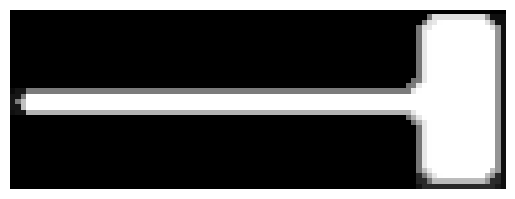

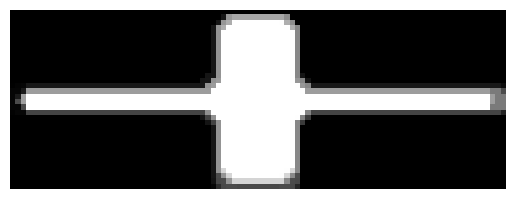

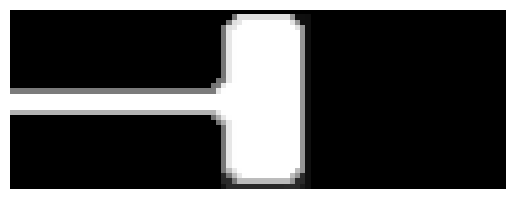

0->1: Got ('Translate X', -37), expected [Translate (-50, 0)]


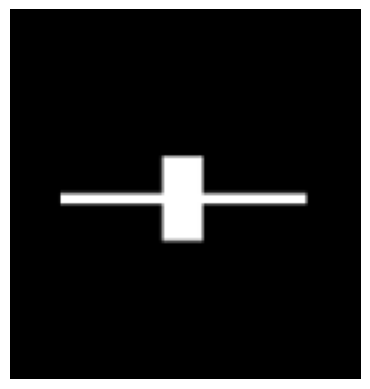

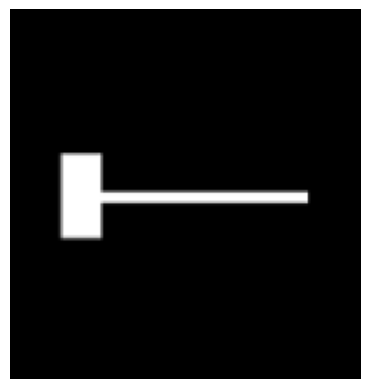

Optimal parameter for Rotate: 12, score: 3.18503199100844e-06
Optimal parameter for Translate X: 1, score: 2.8402234903332895e-06
Optimal parameter for Translate Y: -3, score: 2.812897393461679e-06
Translate Y


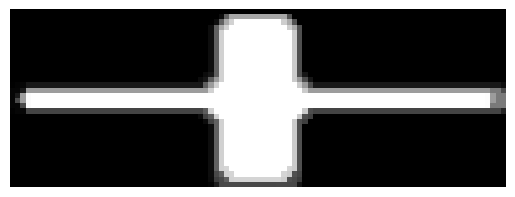

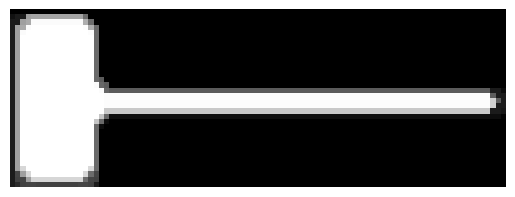

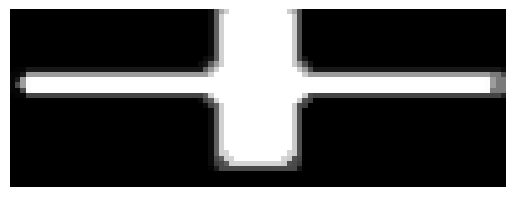

1->2: Got ('Translate Y', -3), expected [Translate (-50, 0)]


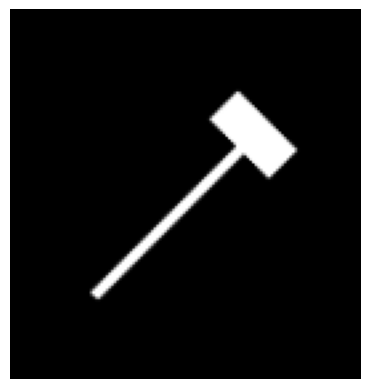

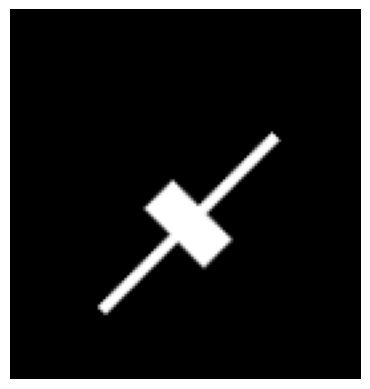

Optimal parameter for Rotate: -97, score: 1.4214844225404001e-06
Optimal parameter for Translate X: 3, score: 1.3104689100315493e-06
Optimal parameter for Translate Y: 3, score: 1.3327580375904748e-06
Translate X


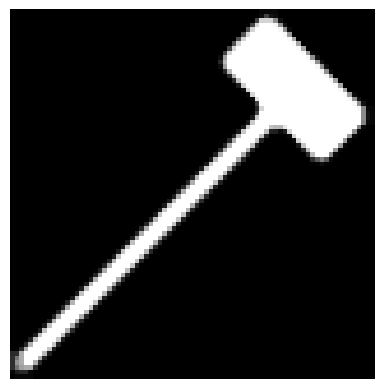

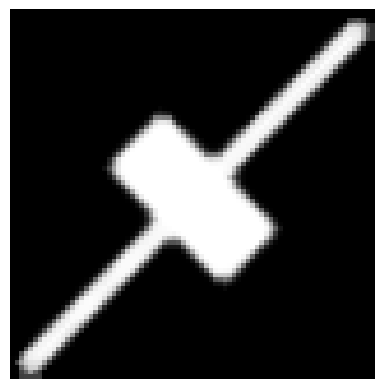

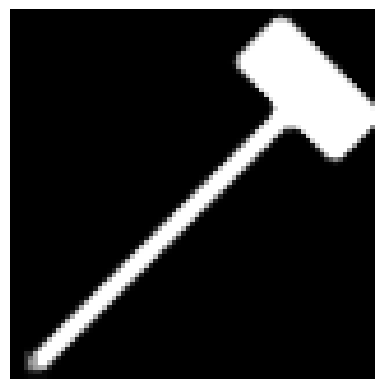

3->4: Got ('Translate X', 3), expected [Translate (-50, -50)]


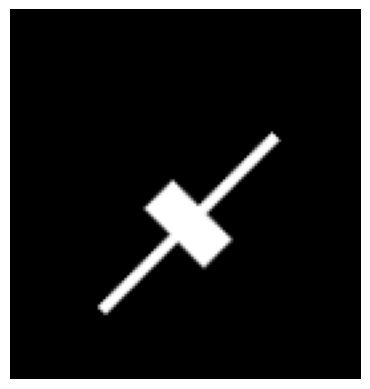

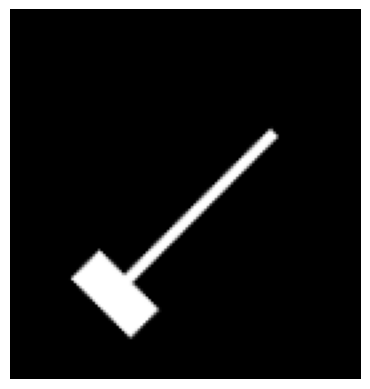

Optimal parameter for Rotate: -159, score: 1.6719282445975468e-06
Optimal parameter for Translate X: 1, score: 1.333353929368195e-06
Optimal parameter for Translate Y: 0, score: 1.2588004619822876e-06
Translate Y


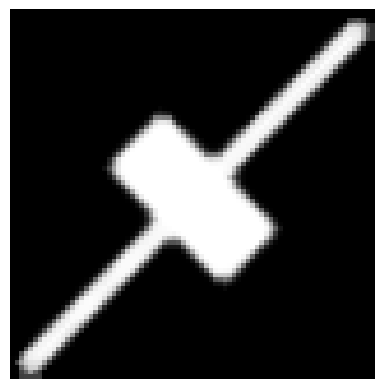

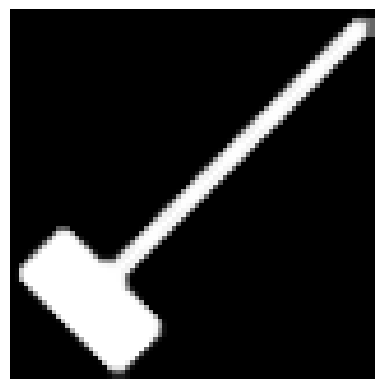

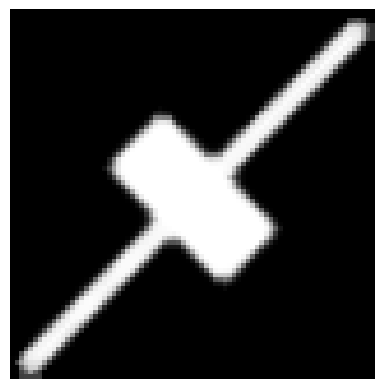

4->5: Got ('Translate Y', 0), expected [Translate (-50, -50)]


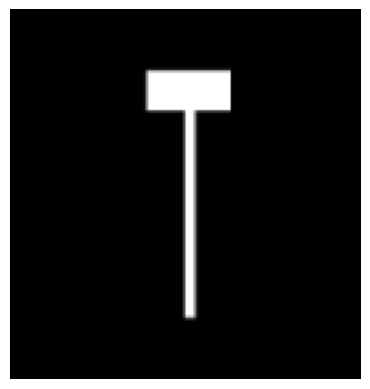

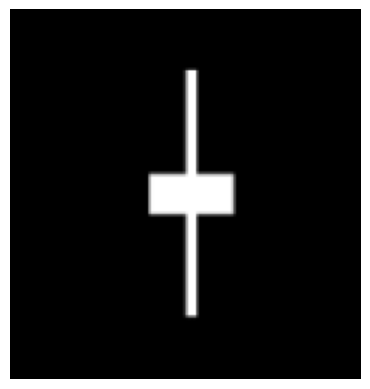

Optimal parameter for Rotate: -1, score: 2.556506802601365e-06
Optimal parameter for Translate X: -5, score: 2.6737144835045505e-06
Optimal parameter for Translate Y: 40, score: 3.0599700036807816e-06
Rotate


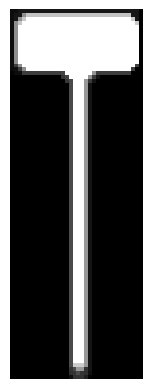

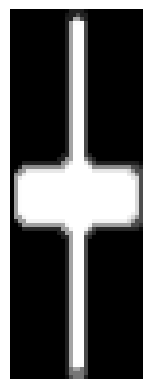

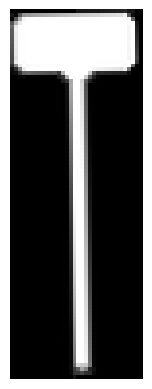

6->7: Got ('Rotate', -1), expected [Translate (0, -50)]
iq10 - Arrows rotating
Correct labels: 
[['Rotate -90', 'Rotate -90'], ['Rotate -90', 'Rotate -90'], ['Rotate -90', 'N/A']]


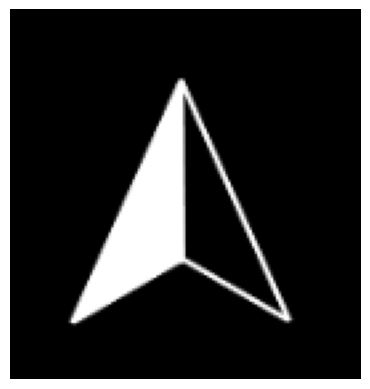

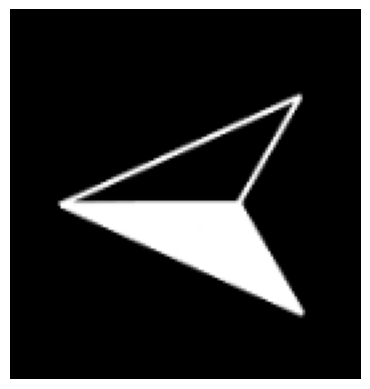

Optimal parameter for Rotate: 36, score: 4.150158454282749e-07
Optimal parameter for Translate X: 21, score: 4.5794270840641203e-07
Optimal parameter for Translate Y: 1, score: 4.304578925533337e-07
Rotate


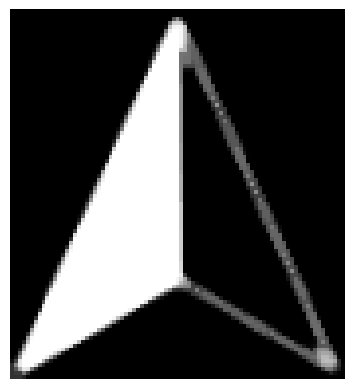

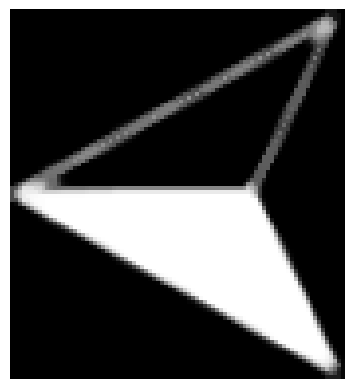

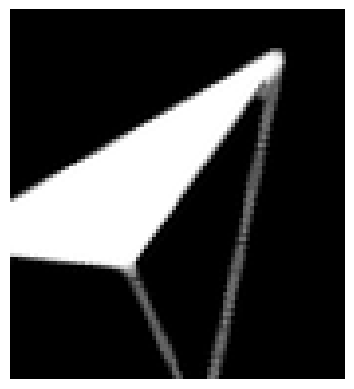

0->1: Got ('Rotate', 36), expected [Rotate -90]


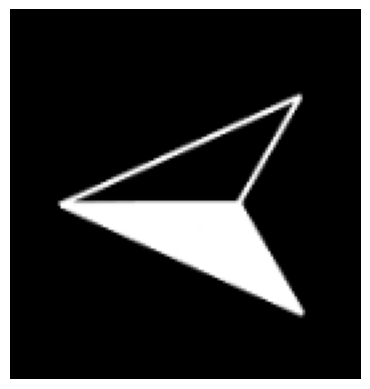

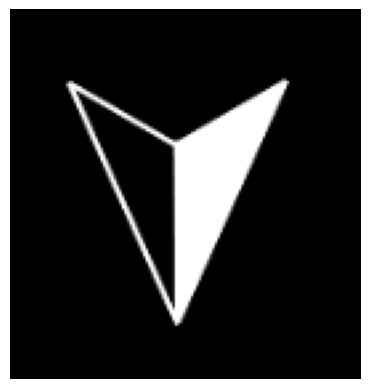

Optimal parameter for Rotate: 29, score: 3.922112761587723e-07
Optimal parameter for Translate X: -5, score: 4.439967918903344e-07
Optimal parameter for Translate Y: -47, score: 4.0229778263299555e-07
Rotate


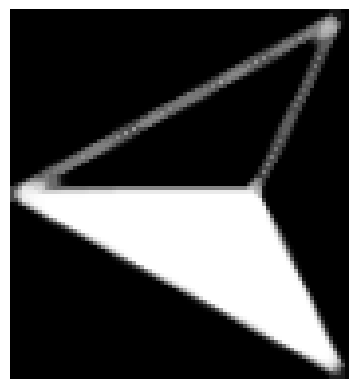

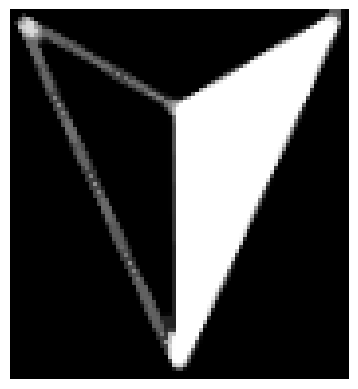

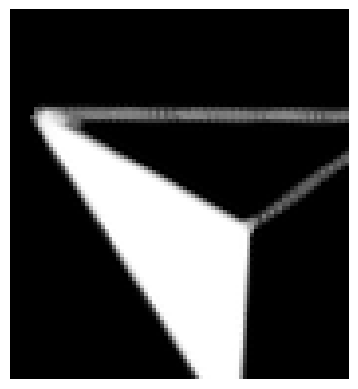

1->2: Got ('Rotate', 29), expected [Rotate -90]


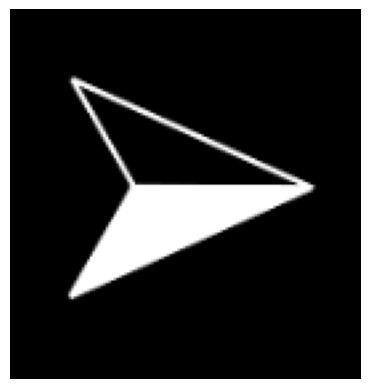

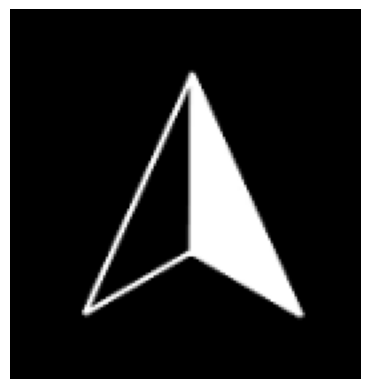

Optimal parameter for Rotate: 38, score: 4.3134116148772996e-07
Optimal parameter for Translate X: 10, score: 4.6071946474544577e-07
Optimal parameter for Translate Y: -26, score: 4.70376691789805e-07
Rotate


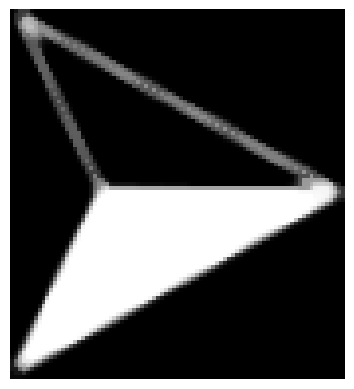

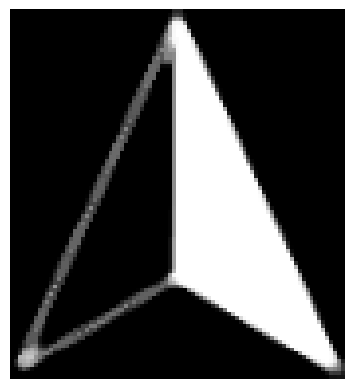

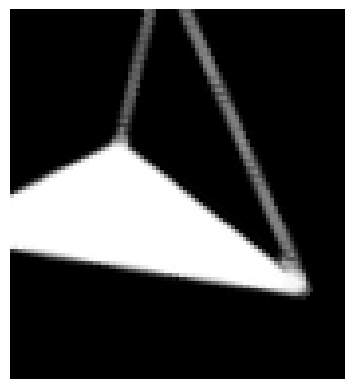

3->4: Got ('Rotate', 38), expected [Rotate -90]


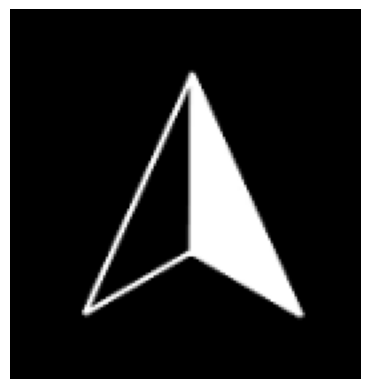

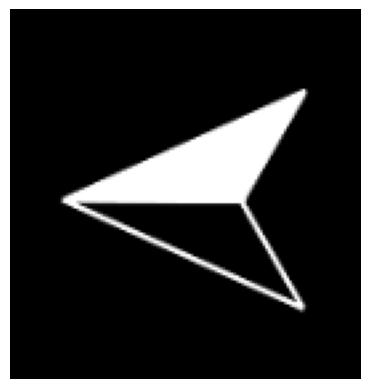

Optimal parameter for Rotate: 4, score: 4.157158815003313e-07
Optimal parameter for Translate X: -1, score: 4.402447472863901e-07
Optimal parameter for Translate Y: -10, score: 4.925347365489215e-07
Rotate


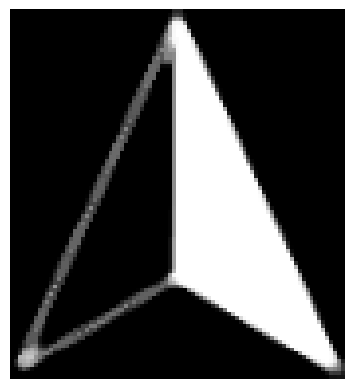

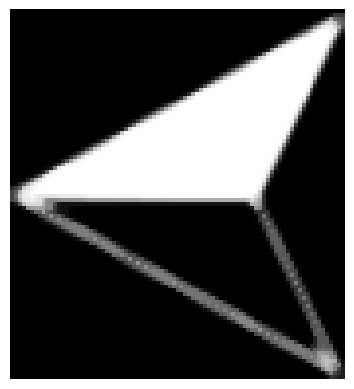

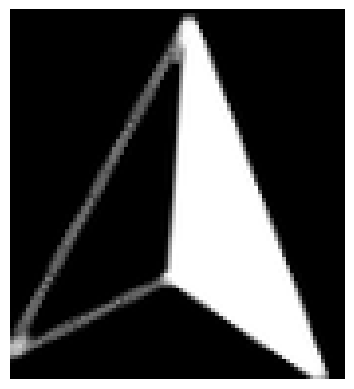

4->5: Got ('Rotate', 4), expected [Rotate -90]


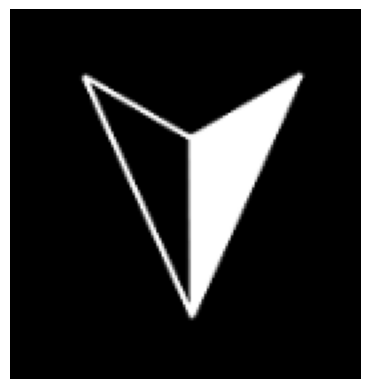

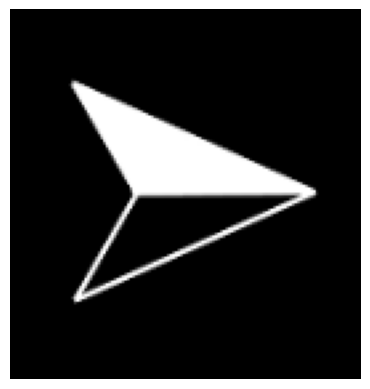

Optimal parameter for Rotate: 49, score: 4.4998243169603174e-07
Optimal parameter for Translate X: -27, score: 4.622645441342903e-07
Optimal parameter for Translate Y: 0, score: 4.595475716741276e-07
Rotate


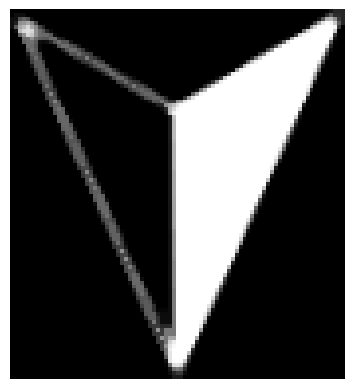

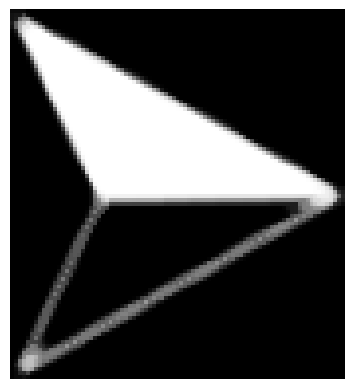

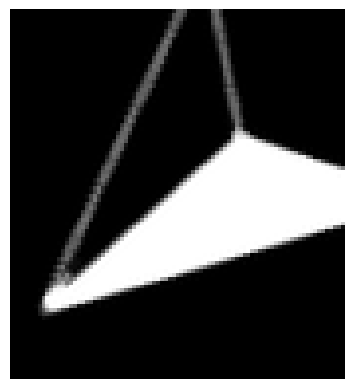

6->7: Got ('Rotate', 49), expected [Rotate -90]
iq16 - Umbrellas rotating
Correct labels: 
[['Rotate 90', 'Rotate 90'], ['Rotate 90', 'Rotate 90'], ['Rotate 90', 'N/A']]


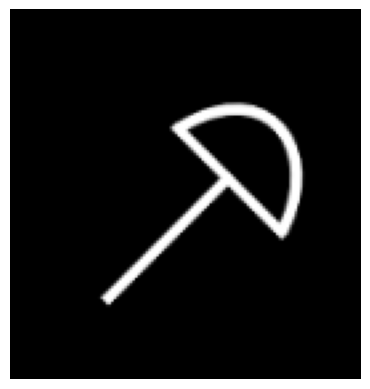

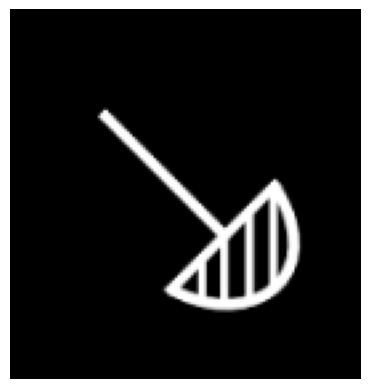

Optimal parameter for Rotate: 91, score: 1.0918119090906789e-06
Optimal parameter for Translate X: -4, score: 1.8340682833729172e-06
Optimal parameter for Translate Y: 21, score: 1.689048143466176e-06
Rotate


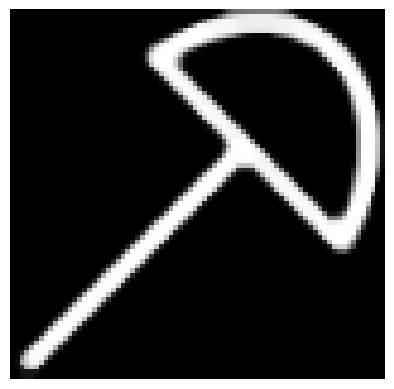

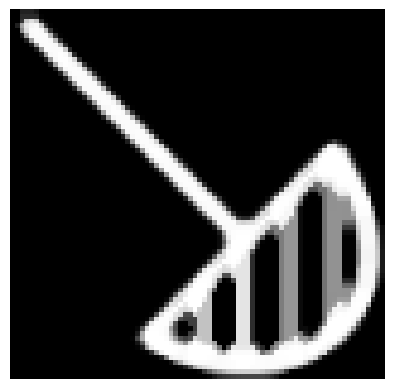

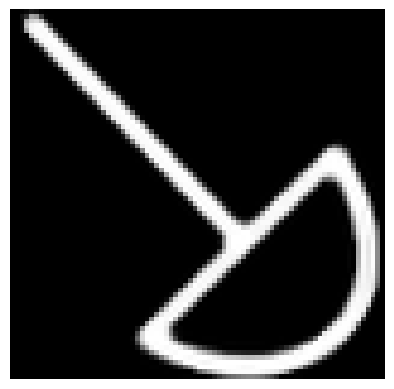

0->1: Got ('Rotate', 91), expected [Rotate 90]


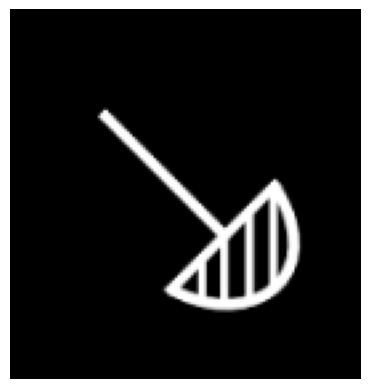

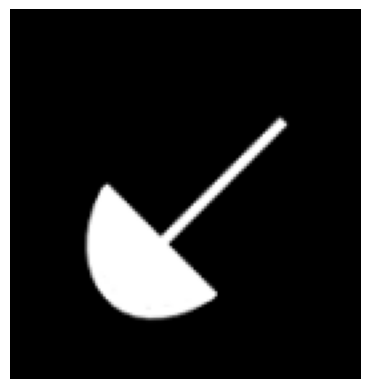

Optimal parameter for Rotate: -79, score: 1.0893352356926833e-06
Optimal parameter for Translate X: -19, score: 1.075547506668716e-06
Optimal parameter for Translate Y: -19, score: 1.1724952467054157e-06
Translate X


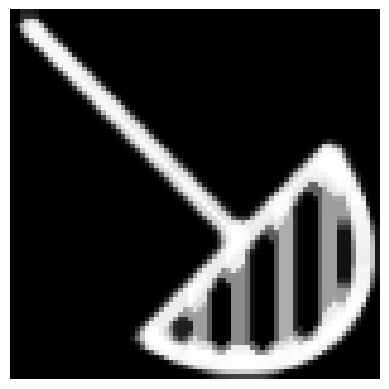

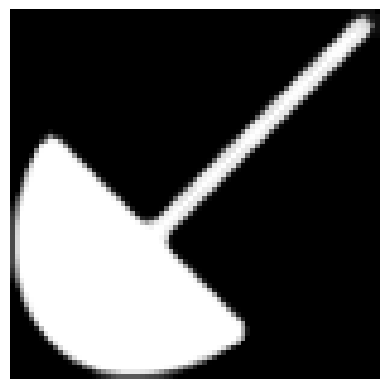

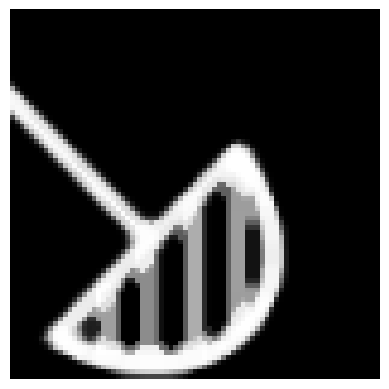

1->2: Got ('Translate X', -19), expected [Rotate 90]


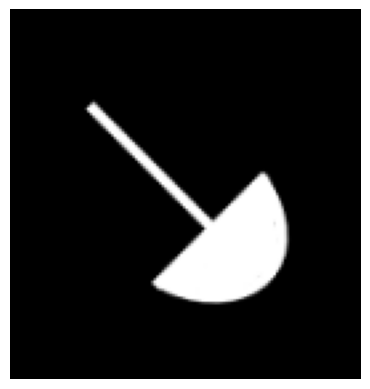

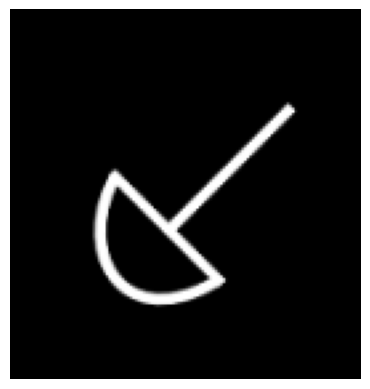

Optimal parameter for Rotate: -92, score: 1.0705690488148011e-06
Optimal parameter for Translate X: -19, score: 9.734408586371376e-07
Optimal parameter for Translate Y: -19, score: 1.1754814994364669e-06
Translate X


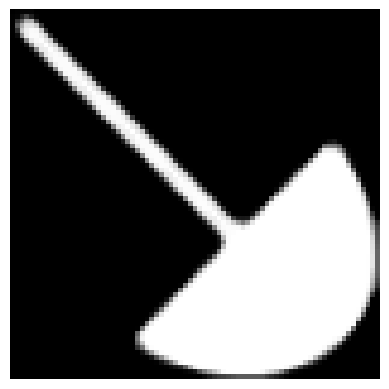

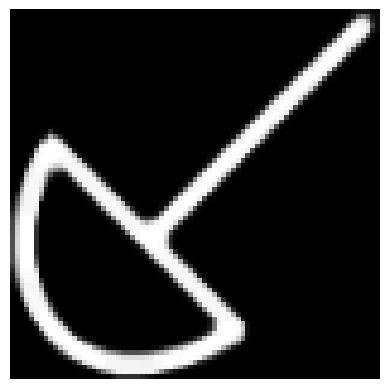

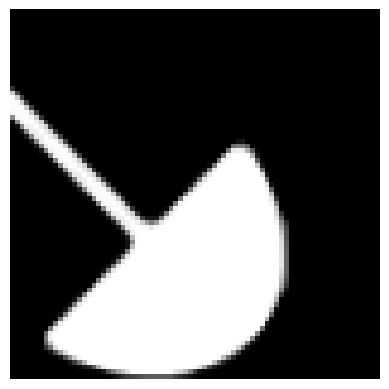

3->4: Got ('Translate X', -19), expected [Rotate 90]


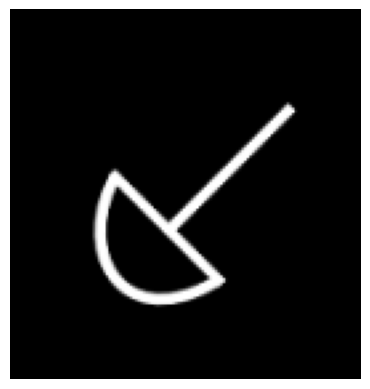

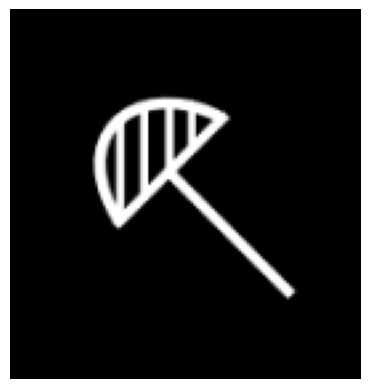

Optimal parameter for Rotate: 91, score: 1.2067283496966266e-06
Optimal parameter for Translate X: 2, score: 2.0010969675745517e-06
Optimal parameter for Translate Y: -19, score: 1.8080207901860513e-06
Rotate


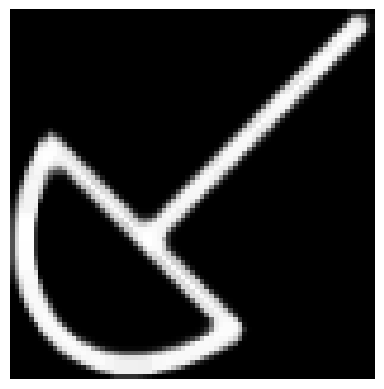

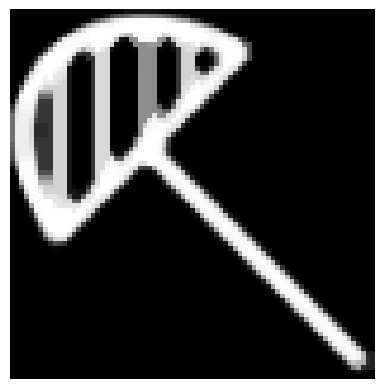

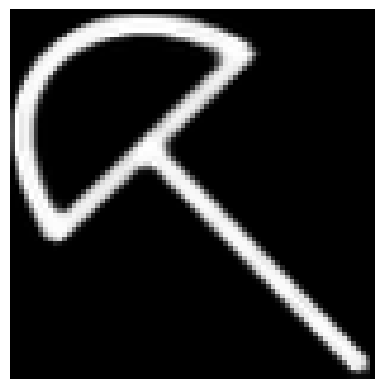

4->5: Got ('Rotate', 91), expected [Rotate 90]


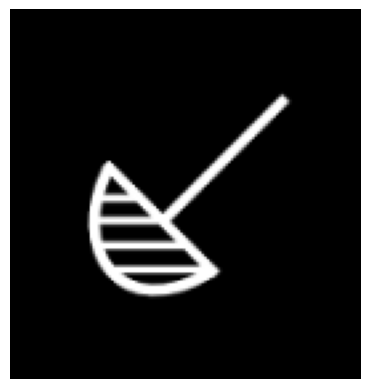

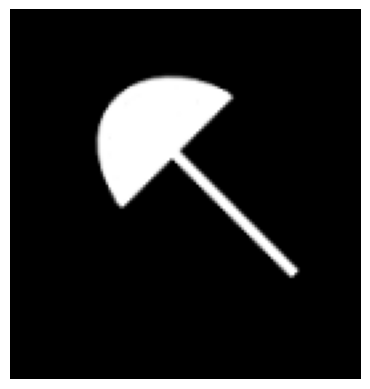

Optimal parameter for Rotate: -75, score: 9.373058693929908e-07
Optimal parameter for Translate X: 21, score: 9.236635524464015e-07
Optimal parameter for Translate Y: 0, score: 9.998291856240287e-07
Translate X


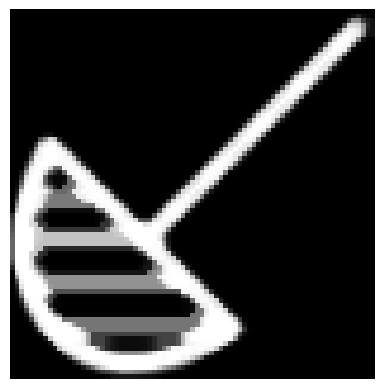

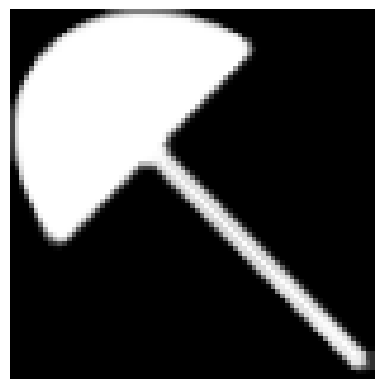

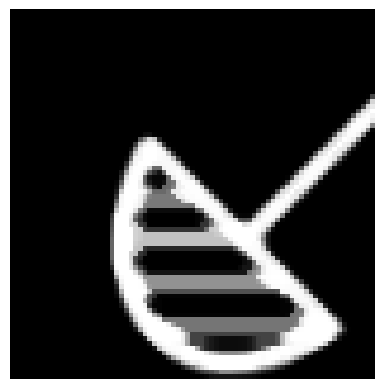

6->7: Got ('Translate X', 21), expected [Rotate 90]
iq17 - Circles rotating
Correct labels: 
[['Rotate 45', 'Rotate 90'], ['Rotate 45', 'Rotate 90'], ['Rotate 45', 'N/A']]


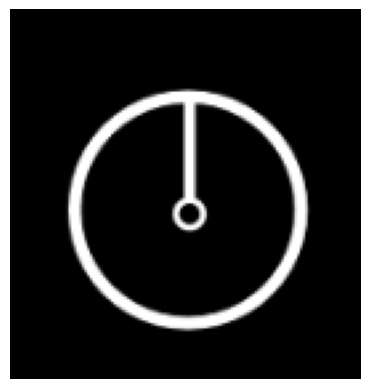

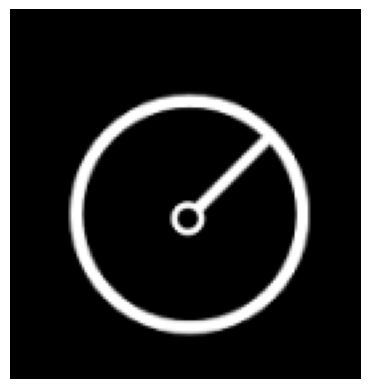

Optimal parameter for Rotate: 46, score: 4.249898908882306e-07
Optimal parameter for Translate X: 1, score: 5.349755475519421e-07
Optimal parameter for Translate Y: 1, score: 5.160887689279876e-07
Rotate


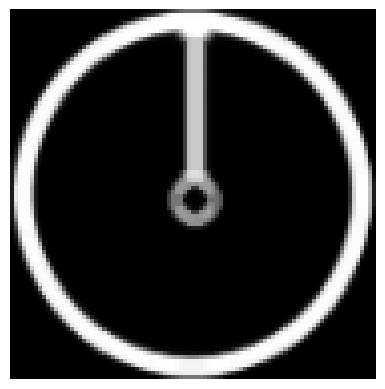

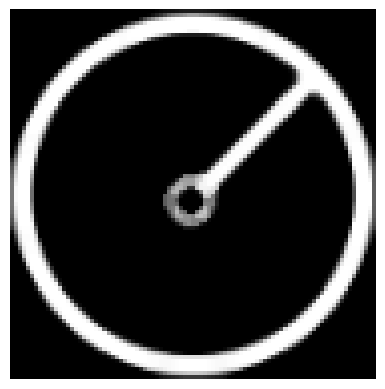

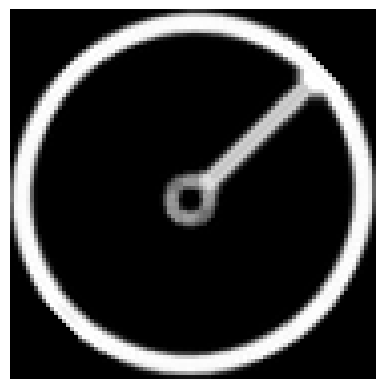

0->1: Got ('Rotate', 46), expected [Rotate 45]


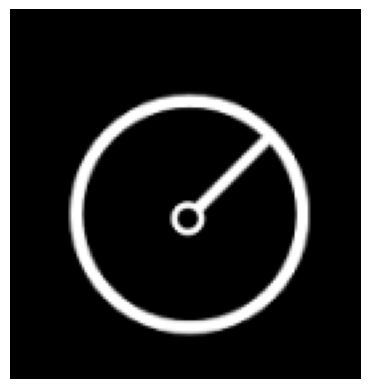

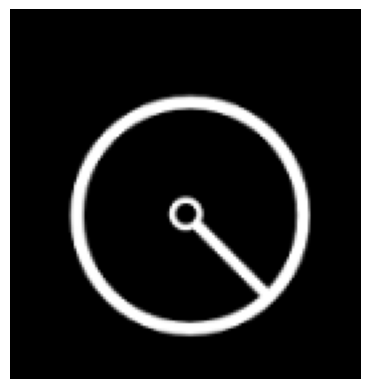

Optimal parameter for Rotate: 89, score: 3.5842300770483624e-07
Optimal parameter for Translate X: 1, score: 5.571206207682886e-07
Optimal parameter for Translate Y: 1, score: 5.735992482923063e-07
Rotate


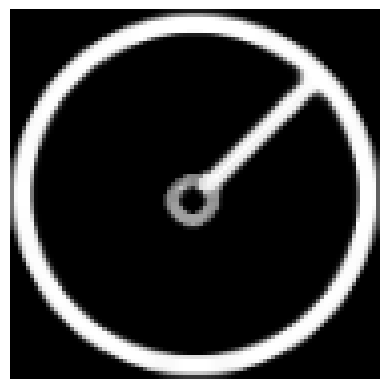

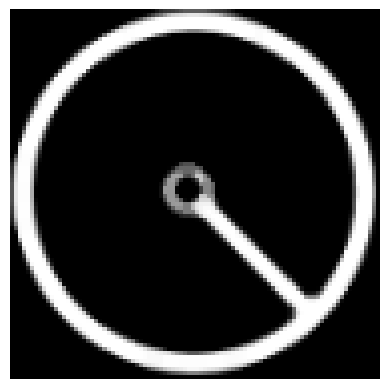

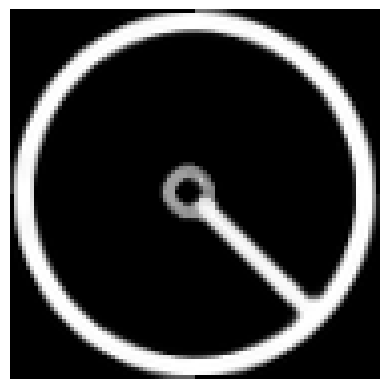

1->2: Got ('Rotate', 89), expected [Rotate 90]


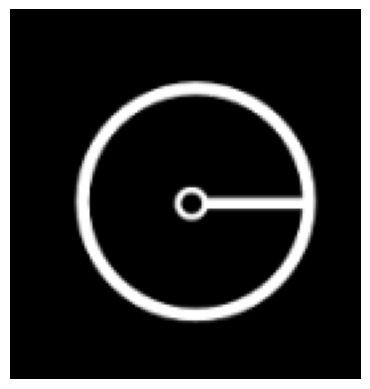

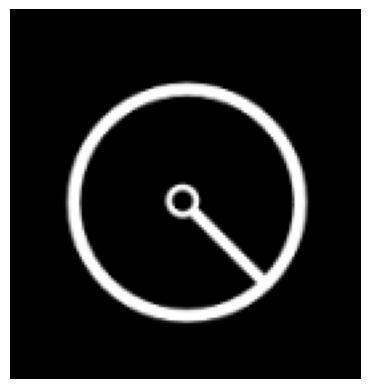

Optimal parameter for Rotate: 109, score: 3.699966810994591e-07
Optimal parameter for Translate X: 1, score: 5.561851829087845e-07
Optimal parameter for Translate Y: 1, score: 5.904144572519624e-07
Rotate


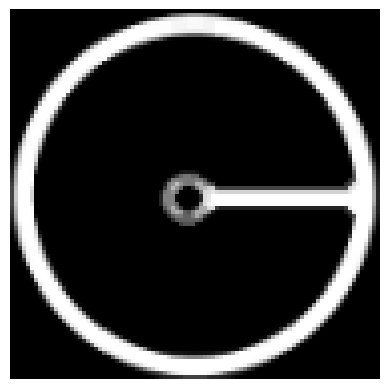

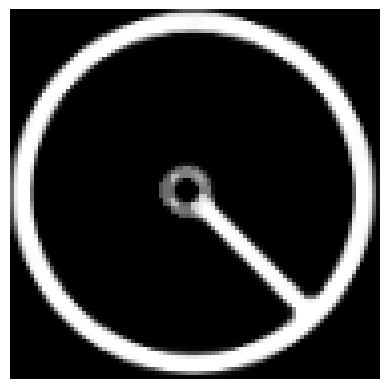

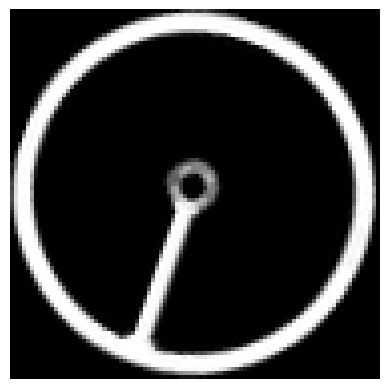

3->4: Got ('Rotate', 109), expected [Rotate 45]


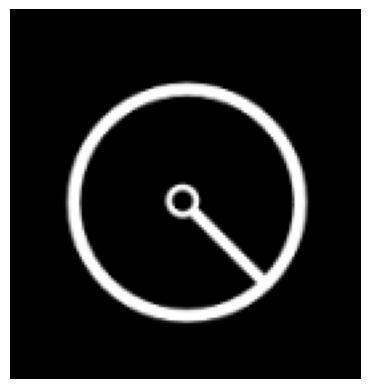

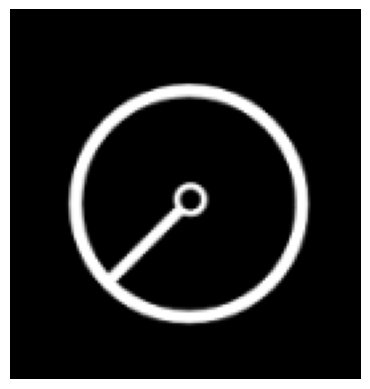

Optimal parameter for Rotate: 179, score: 3.706349758503291e-07
Optimal parameter for Translate X: 1, score: 4.620484394617779e-07
Optimal parameter for Translate Y: 2, score: 5.648912045805518e-07
Rotate


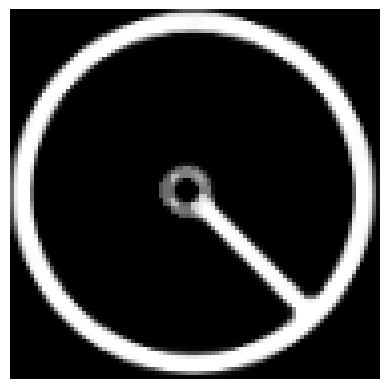

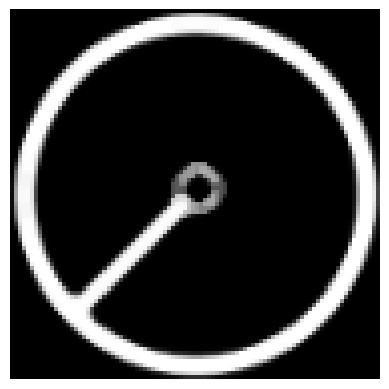

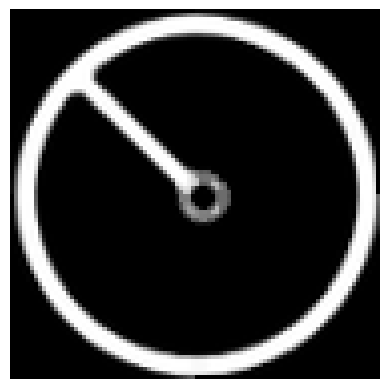

4->5: Got ('Rotate', 179), expected [Rotate 90]


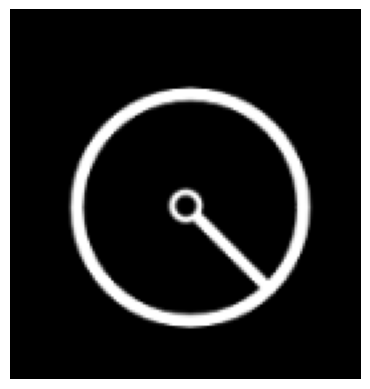

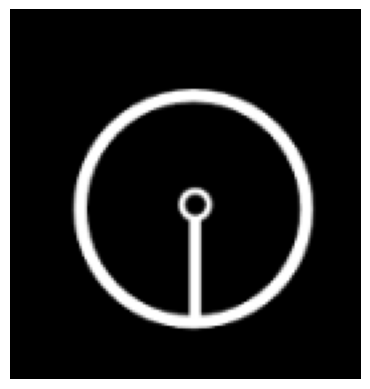

Optimal parameter for Rotate: 76, score: 4.0459431677631447e-07
Optimal parameter for Translate X: 1, score: 4.7411722373272267e-07
Optimal parameter for Translate Y: 1, score: 4.4644100885262603e-07
Rotate


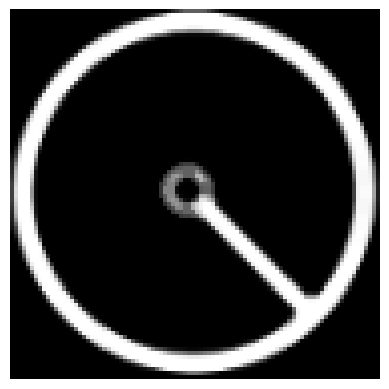

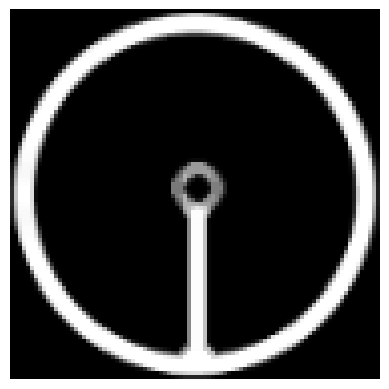

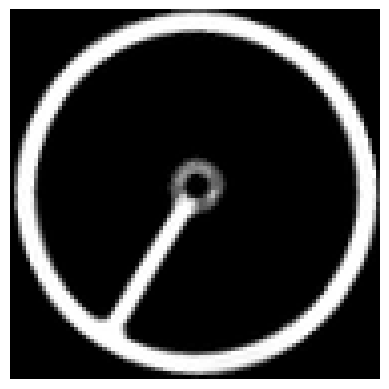

6->7: Got ('Rotate', 76), expected [Rotate 45]


In [16]:
# Gradient descent (or sort of like binary search?) to find the optimal angle, offset, or other parameters

def gradient_descent(create_augmentation, parameter_range, org, dest, debug=False):
    tried_x = []
    tried_y = []
    def score(parameter):
        score = augmentation_score(create_augmentation(parameter), org, dest)
        tried_x.append(parameter)
        tried_y.append(score)
        return score
    start, stop = parameter_range
    golden_ratio = (1 + 5 ** 0.5) / 2
    max_iterations = 100
    tolerance = 3
    for _ in range(max_iterations):
        if debug:
            print(f"Range: {start} - {stop}")
        range_size = stop - start
        if range_size < tolerance:
            break

        mid1 = stop - range_size / golden_ratio
        mid2 = start + range_size / golden_ratio
        # these must be integers
        mid1 = round(mid1)
        mid2 = round(mid2)

        score1 = score(mid1)
        score2 = score(mid2)

        if score1 < score2:
            stop = mid2
        else:
            start = mid1

    optimal_parameter = (start + stop) / 2
    return optimal_parameter, (tried_x, tried_y)

def gradient_descent_2(create_augmentation, parameter_range, org, dest, debug=False):
    tried_x = []
    tried_y = []
    def score(parameter):
        score = augmentation_score(create_augmentation(parameter), org, dest)
        tried_x.append(parameter)
        tried_y.append(score)
        return score
    def avg_score(parameter):
        return np.mean([score(parameter + dx) for dx in [-1, 0, 1]])
    # The idea of this is two try nearby parameters to determine the direction to go
    start, stop = parameter_range
    def converge(init):
        current = init
        max_iterations = 20
        for _ in range(max_iterations):
            current_score = avg_score(current)
            nearby = [current - 10, current + 10]
            nearby_scores = [avg_score(n) for n in nearby]
            if current_score < nearby_scores[0] and current_score < nearby_scores[1]:
                return current, current_score
            if nearby_scores[0] < nearby_scores[1]:
                current = nearby[0]
            else:
                current = nearby[1]
        return current, current_score
    # Try different random initializations
    best_score = float('inf')
    best_parameter = None
    for _ in range(5):
        init = np.random.uniform(start, stop)
        init = round(init)
        parameter, this_score = converge(init)
        if this_score < best_score:
            best_score = this_score
            best_parameter = parameter
    return best_parameter, (tried_x, tried_y)   

# Use gradient_descent to find the best score and parameters for each type of augmentation, and choose the best
def learn_parameters(org, dest):
    # The augmentation could be any of the base augmentations
    augmentations = [RotateAugmentation, lambda dx: TranslateAugmentation(dx, 0), lambda dy: TranslateAugmentation(0, dy)]
    names = ["Rotate", "Translate X", "Translate Y"]
    parameters = [(-180, 180), (-org.shape[1], org.shape[1]), (-org.shape[0], org.shape[0])]
    best_score = float('inf')
    best_result = None
    for name, create_augmentation, parameter_range in zip(names, augmentations, parameters):
        optimal_parameter, _ = gradient_descent(create_augmentation, parameter_range, org, dest)
        optimal_parameter = round(optimal_parameter)
        score = augmentation_score(create_augmentation(optimal_parameter), org, dest)
        print(f"Optimal parameter for {name}: {optimal_parameter}, score: {score}")
        if score < best_score:
            best_score = score
            best_result = (name, optimal_parameter)
    return best_result 


def test_gradient_descent():
    # Test first with rotation
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    org, dest = align_images(org, dest, True)
    org, dest = remove_background(org, dest)
    print("Original:")
    show_image(org)
    print("Destination:")
    show_image(dest)
    print("Trying to find the best angle")
    optimal_angle, (x, y) = gradient_descent(RotateAugmentation, (-180, 180), org, dest)
    print(f"Optimal angle: {optimal_angle}")
    print(f"Tested {len(x)} datapoints")
    # plot the x and y tested
    plt.scatter(x, y)
    plt.show()

def test_multiple():
    names = []
    images = []
    correct_translations = []
    boxes_translating = iq_test_to_squares(get_image('iq_images/iq04.png'))
    names.append("iq04 - Boxes translating")
    images.append(boxes_translating)
    correct_translations.append([["Translate (-50, 0)", "Translate (-50, 0)"],
                                 ["Translate (-50, -50)", "Translate (-50, -50)"],
                                 ["Translate (0, -50)", "N/A"]])
    arrows_rotating = iq_test_to_squares(get_image('iq_images/iq10.png'))
    names.append("iq10 - Arrows rotating")
    images.append(arrows_rotating)
    correct_translations.append([["Rotate -90", "Rotate -90"],
                                 ["Rotate -90", "Rotate -90"],
                                 ["Rotate -90", "N/A"]])
    umbrellas_rotating = iq_test_to_squares(get_image('iq_images/iq16.png'))
    names.append("iq16 - Umbrellas rotating")
    images.append(umbrellas_rotating)
    correct_translations.append([["Rotate 90", "Rotate 90"],
                                 ["Rotate 90", "Rotate 90"],
                                 ["Rotate 90", "N/A"]])
    circles_rotating = iq_test_to_squares(get_image('iq_images/iq17.png'))
    names.append("iq17 - Circles rotating")
    images.append(circles_rotating)
    correct_translations.append([["Rotate 45", "Rotate 90"],
                                 ["Rotate 45", "Rotate 90"],
                                 ["Rotate 45", "N/A"]])
    for name, image, label in zip(names, images, correct_translations):
        print(name)
        print(f"Correct labels: \n{label}")
        transitions = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7)]
        labels = [label[0][0], label[0][1], label[1][0], label[1][1], label[2][0]]
        for l, transition in zip(labels, transitions):
            start, end = transition
            org = image[start]
            dest = image[end]
            show_image(org)
            show_image(dest)
            org, dest = process_images(org, dest, remove_bg=False, align=True)
            best_result = learn_parameters(org, dest)
            name, parameter = best_result
            if best_result[0] == 'Translate X':
                augmented = TranslateAugmentation(parameter, 0)(org)
            elif best_result[0] == 'Translate Y':
                augmented = TranslateAugmentation(0, parameter)(org)
            else:
                augmented = RotateAugmentation(parameter)(org)
            print(best_result[0])
            show_image(org)
            show_image(dest)
            show_image(augmented)
            print(f"{start}->{end}: Got {best_result}, expected [{l}]")


# test_gradient_descent()
test_multiple()

In [17]:
# IQ tests are some type of rule:
# 1. One object is moved in some way, and might have a different shading
# 2. There are many objects, and the rule is that there are more or less in different positions
# 3. bitwise presence of objects/things (like XOR), this is sort of like type 2 in the fact that the number of "things" can change

# Our first goal: given the 8 images, find if this task is type 1 or type 2
def get_rule_type(images):
    # Type 1 sticks out because it always has the same number of objects
    # the issue though is that it might not be the same object (in the case of a shape chase pattern)
    # also, some type 2 patterns might have the same number of objects
    # good examples of type 1: 10, 16, 17. 4 is also good as a translation, but the background changes across rows
    
    def get_num_shapes(img, display = False):
        # Check if there is exactly one object in this
        # if there is, then it's type 1
        # if there is more than one, then it's type 2
        # if there is none, then it's type 3
        # We can check for the number of objects by checking the number of contours
        contours = get_contours(img, False)
        # Note that if an object is hollow, it might have two contours
        # therefore, remove all contours that go from white to black (defines a whole in the object)
        def black_to_white(img, contour):
            # get random pixels inside the contour
            x, y, w, h = cv2.boundingRect(contour)
            x = x + w // 2
            y = y + h // 2
            # print(contour)
            # scatter plot the points in the contour
            x_values = [point[0][0] for point in contour]
            y_values = [point[0][1] for point in contour]
            plt.scatter(x_values, y_values)
            plt.show()
            # Get the average pixel color at these points
            avg_pixel = np.mean([img[y, x] for x, y in zip(x_values, y_values)], axis=0)
            print(avg_pixel)
            shrunken_contour = cv2.approxPolyDP(contour, 0.1 * cv2.arcLength(contour, True), True)
            avg_pixel = np.mean([img[y, x] for x, y in shrunken_contour[:, 0]], axis=0)
            print(avg_pixel)
            # return (img[y, x] == [0, 0, 0]).all()
            return True
        def contour_in_another_contour(contour, contours):
            for other_contour in contours:
                contour = contour.reshape((-1, 1, 2)).astype(np.int32)
                other_contour = other_contour.reshape((-1, 1, 2)).astype(np.int32)
                if cv2.pointPolygonTest(other_contour, (round(contour[0][0][0]), round(contour[0][0][1])), False) > 0:
                    return True
            return False
        contours = [contour for contour in contours if not contour_in_another_contour(contour, contours)]
        if display:
            show_image(draw_contours(img, contours))
        return len(contours)
    
    # get the average number of shapes in the first 8 images
    num_shapes = [get_num_shapes(img, False) for img in images[:8]]
    return np.mean(num_shapes)

print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq10.png')))) # expected 1
print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq16.png')))) # expected 1
print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq17.png')))) # expected 1
print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq09.png')))) # expected > 1


1.0
1.0
1.0
2.75


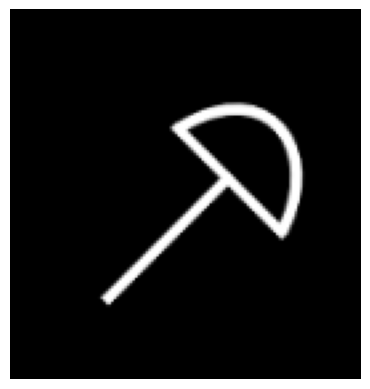

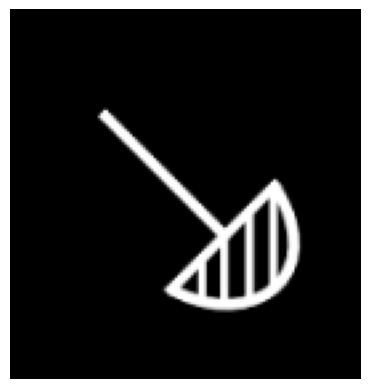

error: OpenCV(4.9.0) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'


In [18]:
def merge_panorama(image1, image2):
    
    # Initialize the feature detector
    sift = cv2.SIFT_create()

    # Detect features and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # Match features
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    # Find homography
    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC)

    # Warp images
    height, width, channels = image1.shape
    result = cv2.warpPerspective(image2, H, (width * 2, height))

    # Copy image1 onto the panorama
    result[0:image1.shape[0], 0:image1.shape[1]] = image1
    return result

# try it out
circles_rotating = iq_test_to_squares(get_image('iq_images/iq16.png'))
img1 = circles_rotating[0]
img2 = circles_rotating[1]
show_image(img1)
show_image(img2)
show_image(merge_panorama(img1, img2))